# Лабораторная 2: Классификатор

> Разработка простых классификаторов: _K-ближайших соседей_ и _наивный байесовский классификатор_.

Используемые библиотеки (включая собственные классификаторы):

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes     import MultinomialNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder

import classifiers.knn
import classifiers.bayes

Далее лабораторная будет разделена на две части для каждого классификатора соответственно.

## Метод _K-ближайших соседей_

Метод _K-ближайших соседей_ описывает данные на основе их близости к `K` другим соседям. 
Так как высчитывается расстояние, проще всего работать с данными, особенности у которых - численные.
Существует множество разных методов для высчитывания расстояния (вплоть до косинусного коэффицента),
но для численных особенностей достаточно расстояние Евклида.

### Рассмотр данных

Для начала необходимо рассмотреть данные, с котороми будет проведена работа. 
[Характеристика красных вин и их оценка](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)
является хорошим кандидатом, в виду того, что все особенности там численные.

In [2]:
data_folder = "data/"
wines = pd.read_csv(data_folder + "winequality-red.csv")
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Датасет предоставлен для обучения машины, способной создать идеальные химические пропорции для 
получения вина высшего качества, но в данном случае ее можно использовать для предсказания оценки
на основе известных данных (используя KNN).

Для начала проверим данные на наличие пустых ячеек и выбросов 
(хотя учитывая алгоритм, они не будут иметь сильного влияния):

In [3]:
wines.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [4]:
wines.agg(['min', 'max'])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
min,4.6,0.12,0.0,0.9,0.012,1.0,6.0,0.99007,2.74,0.33,8.4,3
max,15.9,1.58,1.0,15.5,0.611,72.0,289.0,1.00369,4.01,2.00,14.9,8


В таблице нет ни одной пустой ячейки, и все данные расположены достаточно рядом за исключением "total sulfur dioxide". Рассмотрев её подробнее:

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1079,7.9,0.3,0.68,8.3,0.05,37.5,278.0,0.99316,3.01,0.51,12.3,7
1081,7.9,0.3,0.68,8.3,0.05,37.5,289.0,0.99316,3.01,0.51,12.3,7


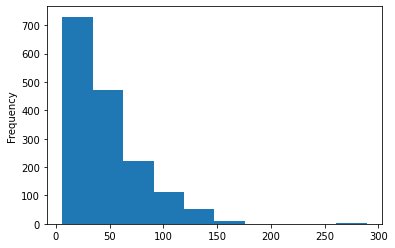

In [5]:
wines["total sulfur dioxide"].plot.hist()
wines.loc[wines["total sulfur dioxide"] > 200]

Видно, что две строки зашли дальше остальных. Эти строки можно исключить но, так как алгоритм работает 
на близости соседей, а не на распределении, их можно игнорировать.

Столбец классов и столбцы особенностей необходимо отделить друг от друга:

In [6]:
X, y = wines.iloc[:, :-1], wines.iloc[:, -1]

### Использование классификатора

Так как у нас нет тестовых данных, придется разделить наши на две части: обучающие и тестовые - и преобразовать 
из таблицы в массивы

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = X_train.values
X_test  = X_test.values
y_train = y_train.values
y_test  = y_test.values


Отправим тренеровочные данных в свой классификатор:

In [8]:
knn_1 = classifiers.knn.KNN(5)
knn_1.train(X_train, y_train)

Теперь можно попробовать классифицировать тренеровочные данные:

In [9]:
%time y_predict = knn_1.predict(X_test)

CPU times: user 3.13 s, sys: 27.3 ms, total: 3.16 s
Wall time: 3.14 s


Полученный результат можно сравнить с реальными классами:

In [10]:
comp = (y_predict == y_test)
comp.sum() / comp.shape[0]

0.5541666666666667

Три запуска показали процент точности, близкий к 50, _в зависимости от того, как данные были разделены_. 
Те же данные можно использовать и для классификатора библиотеки `sklearn`: 

In [11]:
knn_2 = KNeighborsClassifier(5)
knn_2.fit(X_train, y_train)
%time y_predict = knn_2.predict(X_test)
comp = (y_predict == y_test)
comp.sum() / comp.shape[0]

CPU times: user 13.7 ms, sys: 113 µs, total: 13.8 ms
Wall time: 13.9 ms


0.5270833333333333

Который также показывает процент точности, близкий к 50, но имеет значительно большую скорость, так как
он пользуется предварительной обработкой данных для ускорения подсчета расстояния (собственная реализация
пользуется простой реализацией за квадратичное время).

## _Наивный байевский классификатор_

Вся идея байевского классификатора лежит в формуле Теореме Байеса:
$$
    P(c | x_1, x_2, ...) = \frac{P(c) P(x_1 | c) P(x_2 | c) ...}{P(x_1) P(x_2) ...}
$$
То есть вероятность класса $c$ в условиях особенностей $x_1, x_2, ...$ равна вероятности класса $c$ и 
вероятности особенностей $x_1, x_2, ...$ в условиях класса $c$, деленная на вероятность $x_1, x_2, ...$
независимо от класса. Так как мы сравниваем вероятности, делитель можно опустить.

В отличие от _K-ближайших соседей_, здесь не нужно вычислять расстояние и классификатор может принимать
и численные, так и словесные особенности, но для численных значений следует использовать другие методы
высчитывания вероятности, особенно если это значения с плавающей точкой

### Рассмотр данных

[Следующие данные](https://www.kaggle.com/kaushiksuresh147/customer-segmentation) 
содержат результаты разделения людей по категориям и связанные с ними данные и 
используют словесные особенности (к ним также приложены тестовые данные):

In [12]:
customers = pd.read_csv(data_folder + "customer-segmentation/original/Train.csv")
cust_test = pd.read_csv(data_folder + "customer-segmentation/original/Test.csv")
customers

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


Здесь можно заметить присутствие столбца ID, который можно откинуть, так как классификатору он не интересен.
Столбец `Var_1` содержит данных, личные для человека.
Столбец `Segmentation` содержит нужно разделение на классы. Необходимо проверить на пустые ячейки:

In [13]:
customers.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

Более 829 строк содержат пустые значения, от которых избавится трудно, так как наши данные имеют формат опроса
Для начала можно попробовать просто избавится от этих строк:

In [14]:
print("Процент полных строк в тренеровочных данных: ", customers.dropna().shape[0] / customers.shape[0])
print("Процент полных строк в тестовых данных:      ", cust_test.dropna().shape[0] / cust_test.shape[0])

Процент полных строк в тренеровочных данных:  0.8261031234506693
Процент полных строк в тестовых данных:       0.8199467072706509


Значит, выбросив строки с пустыми значениями мы теряем примерно $20\%$ данных, что достаточно много, но взамен
увеличивается точность, так как нет необходимости заполнять пустые значения ложными данными.

In [15]:
customers = customers.dropna()
cust_test = cust_test.dropna()

Так как у нас нет способов проверить корректность словесных данных мы можем только 
проверить их на отсутствие очепяток (кроме столбца `ID`):

In [16]:
for column in customers.drop("ID", axis=1):
    print(f"{column} unique values: ", sorted(customers[column].unique()))

Gender unique values:  ['Female', 'Male']
Ever_Married unique values:  ['No', 'Yes']
Age unique values:  [18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
Graduated unique values:  ['No', 'Yes']
Profession unique values:  ['Artist', 'Doctor', 'Engineer', 'Entertainment', 'Executive', 'Healthcare', 'Homemaker', 'Lawyer', 'Marketing']
Work_Experience unique values:  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
Spending_Score unique values:  ['Average', 'High', 'Low']
Family_Size unique values:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
Var_1 unique values:  ['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6', 'Cat_7']
Segmentation unique values:  ['A', 'B', 'C', 'D']


Здесь видно, что все значения в пределах ожидаемого.

### Работа с данными

Для начала нужно выделить сами данные

In [17]:
X_train, y_train = customers.iloc[:, 1:-1], customers.iloc[:, -1]
X_test,  y_test  = cust_test.iloc[:, 1:-1], cust_test.iloc[:, -1]
type(X_train)

pandas.core.frame.DataFrame

Полученые данные стоит преобразовать в массив:

In [18]:
X_train, y_train = X_train.values, y_train.values
X_test,  y_test  = X_test.values,  y_test.values
type(X_train)

numpy.ndarray

Данные классифицирются по такому же алгоритму:

In [19]:
bayes = classifiers.bayes.Bayes()
bayes.train(X_train, y_train)
%time y_predict = bayes.predict(X_test)
comp = (y_predict == y_test)
comp.sum() / comp.shape[0]

CPU times: user 56.4 ms, sys: 4.18 ms, total: 60.6 ms
Wall time: 52.6 ms


0.32729805013927576

Собственный Байевский классификатор дает точность $32\%$. Для сравнения с `sklearn` необходимо 
закодировать данные в численный формат:

In [20]:
feats_encoders = [LabelEncoder() for _ in range(X_train.shape[1])]
for i in range(X_train.shape[1]):
    X_train[:, i] = feats_encoders[i].fit_transform(X_train[:, i])
    X_test[:, i] = feats_encoders[i].transform(X_test[:, i])

goal_encoder = LabelEncoder()
y_train = goal_encoder.fit_transform(y_train)
y_test  = goal_encoder.transform(y_test)

Теперь, данные можно использовать для байевского классификатора. Самый ближайший из доступных: `MultinomialNB`

In [21]:
# alpha используется для смягчения, 0 для работы схожей с собственным классификатором
mnb = MultinomialNB(alpha=0)
mnb.fit(X_train, y_train)
%time y_predict = mnb.predict(X_test)
comp = (y_predict == y_test)
comp.sum() / comp.shape[0]

CPU times: user 659 µs, sys: 199 µs, total: 858 µs
Wall time: 746 µs


/home/rookstar/Documents/venvs/machine_learning/lib/python3.9/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


0.32729805013927576

Хотя если оставить коэффициент смягчения равным единице, то результат не изменится:

In [22]:
mnb = MultinomialNB(alpha=1)
mnb.fit(X_train, y_train)
%time y_predict = mnb.predict(X_test)
comp = (y_predict == y_test)
comp.sum() / comp.shape[0]

CPU times: user 734 µs, sys: 221 µs, total: 955 µs
Wall time: 962 µs


0.32729805013927576

Таким образом, наш классификатор хоть и медленее, но дает тот же результат